In [1]:
using QuantumOptics
import PhysicalConstants.CODATA2018: c_0
using Unitful
using PyPlot
using LinearAlgebra
using CollectiveSpins

### Parameters

In [19]:
# Nbr of particles
N = 2

# Normalisation parameters
λ = 421e-9
ω0 = (2π*ustrip(c_0)/λ)

# Physical values
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω = 1e7 # Taken from Barbut arXiv:2412.02541v1
γ = 32.7e6 # In Hz

# Position of atoms
a = 1e-6 # Distance between atoms
r0 = [[0, 0, 0], [a, 0, 0]]

# Normalization
ωl = ωl / ω0
kl = kl * λ
r0 = r0 / λ
Ω = Ω / (ω0/2π)
γ = γ / (ω0/2π)


# Integration parameter
tstep = 0.1 * (ω0/2π)
T = [0:tstep:10*(ω0/2π);]; # Normalised time

### Parametrisation

In [20]:
# Basis
b1 = SpinBasis(1//2)
bmb = tensor([b1 for i = 1:N]...)

# One body operators
σp = sigmap(b1)
σm = sigmam(b1)
nup = σp*σm
ndown = σm*σp

# Many body operators
Jz = sum([embed(bmb, i, -8*ndown) for i = 1:N]) + sum([embed(bmb, i, -9*nup) for i = 1:N]) # 2 level system but GS has mJ = -8, ES has mJ = -9
Nup = sum([embed(bmb, i, nup) for i = 1:N]);

### Hamiltonians

In [21]:
H0 = 1/2*Jz
HRO = -Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)*embed(bmb, i, σm) for i = 1:N]));

In [22]:
J = [embed(bmb, i, σm) for i = 1:N];

# Spontaneous emission no $H$

In [23]:
# Initial state
Ψ0_mb = tensor([spinup(b1) for i = 1:N]...)
Γse = γ * Matrix(I, N, N) # Normalized Γ

# Time evolution
ρt_se = timeevolution.master(T, Ψ0_mb, sparse(one(bmb)), J; rates=Γse, dt=tstep)[2];

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\gwbNe\src\integrator_interface.jl:589


In [16]:
figure()
plot(T, real(expect(Nup, ρt_se)))
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\uparrow \uparrow \rangle $")
pygui(false); gcf()
#pygui(true); show()

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\Joschka\.julia\packages\PyCall\1gn3u\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (101,) and (1,)')
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\pyplot.py", line 3838, in plot
    return gca().plot(
           ~~~~~~~~~~^
        *args,
        ^^^^^^
    ...<3 lines>...
        **kwargs,
        ^^^^^^^^^
    )
    ^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py", line 1777, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_base.py", line 297, in __call__
    yield from self._plot_args(
               ~~~~~~~~~~~~~~~^
        axes, this, kwargs, ambiguous_fmt_datakey=ambiguous_fmt_datakey,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        return_kwargs=return_kwargs
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_base.py", line 494, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
                     f"have shapes {x.shape} and {y.shape}")


# Without interactions

In [8]:
# Initial state
Ψ0_mb = tensor([spindown(b1) for i = 1:N]...)

# Time evolution
Γnoint = γ * Matrix(I, N, N) # Normalized Γ
ρt_indep = timeevolution.master(T, Ψ0_mb, H0 + HRO, J; rates=Γnoint, dt=tstep)[2];

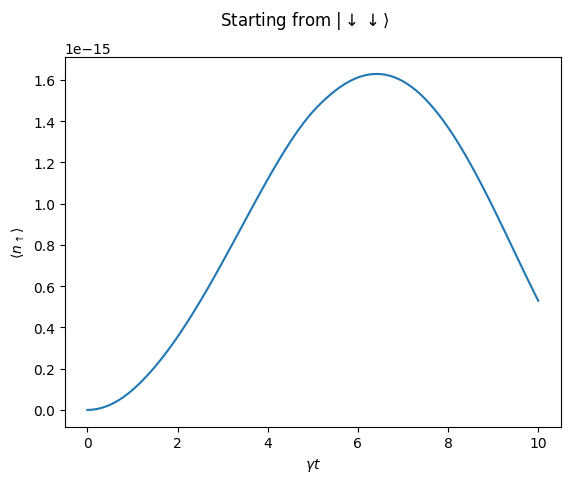

In [9]:
figure()
plot(T, real(expect(Nup, ρt_indep)))
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\downarrow \downarrow \rangle $")
pygui(false); gcf()
#pygui(true); show()

# Without interactions, varying $\Omega$

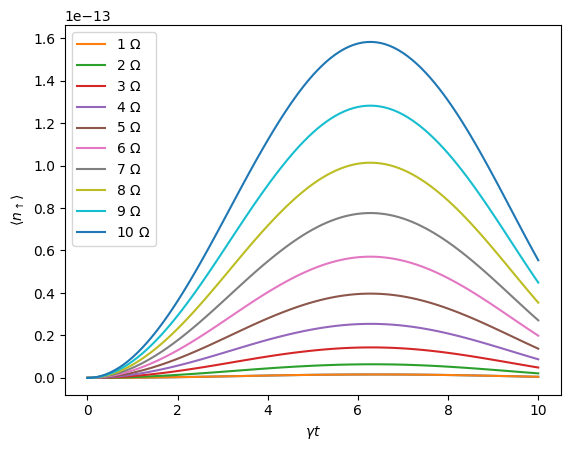

In [10]:
figure()
plot(T, real(expect(Nup, ρt_indep)))
for i in range(1, 10)
    HRO_var = -i*Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)*embed(bmb, i, σm) for i = 1:N]))
    ρt_indep_var_Ω = timeevolution.master(T, Ψ0_mb, H0 + HRO_var, J; rates=Γnoint, dt=tstep)[2]
    plot(T, real(expect(Nup, ρt_indep_var_Ω)), label=string(i)*L" $\Omega$")
end
legend()
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
pygui(false); gcf()

# With electric interactions

In [57]:
# Compute the Ω and Γ matrices of the electric dipole-dipole interaction using CollectiveSpins
e = [0, 0, 1.] # Quantization axis along z
system = SpinCollection(r0, e, gammas=1.)
Ω_CS = interaction.OmegaMatrix(system)
Γ_CS = interaction.GammaMatrix(system);

H_elec = sum([sum([Ω_CS[i, j]*embed(bmb, i, σp)*embed(bmb, j, σm) for j = 1:N if i≠j]) for i = 1:N]);

In [58]:
# Initial state
Ψ0_mb = tensor([spindown(b1) for i = 1:N]...)

# Time evolution
Γ = 1. * Matrix(I, N, N) # Normalized Γ
ρt_elec = timeevolution.master(T, Ψ0_mb, H0 + HRO + H_elec, J; rates=Γ_CS, dt=tstep)[2];

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\gwbNe\src\integrator_interface.jl:589


In [59]:
figure()
plot(T, real(expect(Nup, ρt_elec)), label="Electric interactions")
plot(T, real(expect(Nup, ρt_indep)), label="Independant case")
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\downarrow \downarrow \rangle $")
legend()
pygui(false); gcf()
#pygui(true); show()

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\Joschka\.julia\packages\PyCall\1gn3u\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (101,) and (1,)')
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\pyplot.py", line 3838, in plot
    return gca().plot(
           ~~~~~~~~~~^
        *args,
        ^^^^^^
    ...<3 lines>...
        **kwargs,
        ^^^^^^^^^
    )
    ^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py", line 1777, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_base.py", line 297, in __call__
    yield from self._plot_args(
               ~~~~~~~~~~~~~~~^
        axes, this, kwargs, ambiguous_fmt_datakey=ambiguous_fmt_datakey,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        return_kwargs=return_kwargs
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_base.py", line 494, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
                     f"have shapes {x.shape} and {y.shape}")


# With electric interactions, varying $\Omega$

In [60]:
close("all")
figure()
for i in range(1, 10)
    HRO_var = -i*Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)*embed(bmb, i, σm) for i = 1:N]))
    ρt_elec_var_Ω = timeevolution.master(T, Ψ0_mb, H0 + HRO_var + H_elec, J; rates=Γ_CS, dt=tstep)[2]
    line, = plot(T, real(expect(Nup, ρt_elec_var_Ω)), label=string(i)*L" $\Omega$")

    # Without interactions
    ρt_indep_var_Ω = timeevolution.master(T, Ψ0_mb, H0 + HRO_var, J; rates=Γ, dt=tstep)[2]
    plot(T, real(expect(Nup, ρt_indep_var_Ω)), color = line.get_color(), linestyle="--")
end
legend()
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
pygui(false); gcf()
#pygui(true); show()

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\gwbNe\src\integrator_interface.jl:589


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\Joschka\.julia\packages\PyCall\1gn3u\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (101,) and (1,)')
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\pyplot.py", line 3838, in plot
    return gca().plot(
           ~~~~~~~~~~^
        *args,
        ^^^^^^
    ...<3 lines>...
        **kwargs,
        ^^^^^^^^^
    )
    ^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py", line 1777, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_base.py", line 297, in __call__
    yield from self._plot_args(
               ~~~~~~~~~~~~~~~^
        axes, this, kwargs, ambiguous_fmt_datakey=ambiguous_fmt_datakey,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        return_kwargs=return_kwargs
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\Joschka\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_base.py", line 494, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
                     f"have shapes {x.shape} and {y.shape}")


# Brouillons

In [61]:
# deg = 1
# E0 = 1
# Ω = deg*E0/ustrip(ħ) 
# H0 = -Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)embed(bmb, i, σm) for i = 1:N])) + ustrip(ħ)*ω0/2*Jz

# Physical constants
#ħ = 1.